In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Data = pd.read_csv(r'D:\Desktop\현대제철\MiningProcess_Flotation_Plant_Database.csv')
# Data.isnull().sum()

In [ ]:
plt.scatter(Data[Data.columns[2]],Data[Data.columns[-1]],s=1)

In [ ]:
Data1 = Data.sample(frac=0.01)

In [ ]:
Data.describe()

In [ ]:
Data1.shape

In [ ]:
plt.scatter(Data1[Data1.columns[1]],Data1[Data1.columns[-1]],s=1)

In [ ]:
plt.scatter(Data1[Data1.columns[2]],Data1[Data1.columns[-1]],s=1)

In [ ]:
# extra 부분 test set으로 interpo 부분 랜덤하게 섞어서 train, validation set으로 나누어서 진행
plt.scatter([i for i in range(len(Data))],Data[Data.columns[-1]],s=1)
plt.xticks([])
plt.yticks([])

In [ ]:
plt.scatter([i for i in range(len(Data))],Data[Data.columns[-2]],s=1)
plt.xticks([])
plt.yticks([])

In [ ]:
data_file_directory = 'D:\Desktop\현대제철\MiningProcess_Flotation_Plant_Database.csv'
save_ANN_model_directory = './model/ANN_model'
standardization = True
normalization = False
max_norm = 1
min_norm = 0

number_of_k_folds = 5
number_of_averaging = 1

num_layer = 8
num_neuron = 40
activation_function = 'elu'
learning_rate = 0.00001
l2_reg = 0.000001
batch_norm_momentum = 0.9
initializer = 'he_normal'

Endure_overfitting_step = 20
epochs = 1000
batch_size = 1024
shuffle = True
print_step = 100
using_device = '/GPU:0'

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import utils
from functools import partial
import os
import sys
mod = sys.modules[__name__]
tf.set_random_seed(777)

if os.path.isdir('./save') == False:
    os.mkdir('./save')

if os.path.isdir('./model') == False:
    os.mkdir('./model')

def stz(Data):
    return (Data - Data.mean())/Data.std()

def norm(Data, max_norm=1, min_norm=0):

    Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm

    return Data

def preprocessing_Data(Data, standardization=True, normalization=True, max_normalization=1, min_normalization=0):
    if standardization:
        std_Data = stz(Data)
    else:
        std_Data = Data

    if normalization:
        normm_Data = norm(std_Data,max_normalization, min_normalization)
    else:
        normm_Data = std_Data

    return normm_Data

def pretreat_Data(Data, origin_Data, standardization=True, normalization=True):
    if standardization:
        std = origin_Data.std()
        mean = origin_Data.mean()

        stz_Data = stz(origin_Data)
    else:
        std = 1
        mean = 0
    if normalization:
        max_stz_Data = stz_Data.max()
        min_stz_Data = stz_Data.min()
    else:
        max_stz_Data = Data.max()
        min_stz_Data = Data.min()

    denorm_Data = norm(Data,max_stz_Data,min_stz_Data)
    destz_Data  = denorm_Data*std + mean

    return destz_Data
    
####### import input parameters #############

# from input import *
# print('input parameter loading complete')

##################################################################################################################################
save_file_name = 'l{}_n{}_{}'.format(num_layer,num_neuron,activation_function)

####################################################################

### Load Data & preprocessing ###

Data = pd.read_csv(r'%s'%data_file_directory)
Data = Data[Data.columns[1:]]
Data = Data.stack().str.replace(',','.').unstack()
Data = Data.astype(float)

print(Data.head(5))

preprocessed_Data = preprocessing_Data(Data,standardization,normalization,max_norm,min_norm)

Train_Data = preprocessed_Data.sample(frac=0.8)
Test_Data  = preprocessed_Data.drop(Train_Data.index)

X_Train_Data = Train_Data[Train_Data.columns[:-2]]
Y_Train_Data = Train_Data[Train_Data.columns[-2:]]
X_Test_Data  = Test_Data[Test_Data.columns[:-2]]
Y_Test_Data  = Test_Data[Test_Data.columns[-2:]]

X_Data_for_model = preprocessed_Data[preprocessed_Data.columns[:-2]]
Y_Data_for_model = preprocessed_Data[preprocessed_Data.columns[-2:]]

print('Load Data & preprocessing complete')
### 

### Define Network Sturucture ###
with tf.device(using_device):

    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)
    batch_prob = tf.placeholder(tf.bool)

    dense_layer = partial(tf.layers.dense, activation=None, kernel_initializer=getattr(tf.keras.initializers,initializer)(), use_bias=True, kernel_regularizer=l2_regularizer)
    batch_norm_layer = partial(tf.layers.batch_normalization, training=batch_prob, momentum=batch_norm_momentum)

    X = tf.placeholder(tf.float32, shape=[None, len(X_Train_Data.columns)])
    Y = tf.placeholder(tf.float32, shape=[None, len(Y_Train_Data.columns)])

    for i in range(num_layer):
        
        if i == 0:
            setattr(mod, 'hidden{}'.format(i+1),dense_layer(X,num_neuron))

        else:
            setattr(mod, 'hidden{}'.format(i+1),dense_layer(getattr(mod, 'BN{}_act'.format(i)),num_neuron))
        
        setattr(mod, 'BN{}'.format(i+1),batch_norm_layer(getattr(mod, 'hidden{}'.format(i+1))))
        setattr(mod, 'BN{}_act'.format(i+1),getattr(tf.nn,activation_function)(getattr(mod, 'BN{}'.format(i+1))))

    model = dense_layer(getattr(mod,'BN{}_act'.format(num_layer)), len(Y_Train_Data.columns), use_bias=False)

    reconstruction_loss = tf.reduce_mean(tf.square(model - Y))
#     reconstruction_loss = tf.reduce_mean(tf.abs((model - Y)/Y))
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_losses)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
          train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    saver = tf.train.Saver()

    print('Define Network Structure complete')

###

### training ###

    print('training start')
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    train_rmse = []
    test_rmse  = []
    loss_value_test = 9999
    num_over = 0

    for epoch_index in range(epochs):
        X_Train_batch = X_Train_Data.sample(n=4)
        Y_Train_batch = Y_Train_Data.loc[X_Train_batch.index]
        sess.run(train_op, feed_dict={X: X_Train_batch, Y: Y_Train_batch, batch_prob:True})
 
        if loss_value_test <= sess.run(loss, feed_dict={X: X_Test_Data, Y: Y_Test_Data, batch_prob:False}):
            num_over += 1
        else:
            num_over = 0

        if num_over == Endure_overfitting_step:
            print('over fitting occurs!')
            break

        loss_value_train = sess.run(loss, feed_dict={X: X_Train_Data, Y: Y_Train_Data, batch_prob:True})
        loss_value_test  = sess.run(loss, feed_dict={X: X_Test_Data , Y: Y_Test_Data , batch_prob:False})

        if (epoch_index+1)%print_step == 0:
            print('epoch: {}/{}, train loss: {:.4e}, test loss: {:.4e}'.format(epoch_index+1,epochs,loss_value_train,loss_value_test))
            train_rmse.append(loss_value_train)
            test_rmse.append(loss_value_test)

    epoch_index1 = [(i+1)*print_step for i in range(len(train_rmse))]
    plt.plot(epoch_index1, train_rmse)
    plt.plot(epoch_index1, test_rmse)
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend(['train','test'])
    plt.savefig(r'./save/l%d_n%d_%s.png'%(num_layer,num_neuron,activation_function))
    plt.close()

In [4]:
def stz(Data):
    return (Data - Data.mean())/Data.std()

def norm(Data, max_norm=1, min_norm=0):

    Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm

    return Data

Data = Data[Data.columns[1:]]
Data = Data.stack().str.replace(',','.').unstack()
Data = Data.astype(float)


In [ ]:
stz(Data).boxplot()

In [5]:
stz_Data = stz(Data)
X_Data = stz_Data[Data.columns[:-2]]
Y_Data = stz_Data[Data.columns[-2:]]

X_train = X_Data.sample(frac=0.7)
Y_train = Y_Data.loc[X_train.index]

print(X_train.head())
print(Y_train.head())

        % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  Ore Pulp Flow  \
246925     1.499737      -1.232727     0.546797    0.152014       0.326464   
504569     0.499300      -0.790564     1.135612    0.774305      -0.307777   
391486    -0.702776       0.474229    -1.375692   -2.497009       1.500539   
87693     -0.555425       0.358179    -1.247931    0.287374       0.188729   
117617     0.160004      -0.236758     0.026769   -0.550043       0.281824   

        Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
246925    -0.245703          0.160729                      0.684276   
504569     1.772993          0.356545                     -1.028951   
391486    -1.440305         -2.316842                      0.664831   
87693     -0.642439          0.770703                     -1.015177   
117617    -0.355416          0.913233                     -2.023911   

        Flotation Column 02 Air Flow  Flotation Column 03 Air Flow  ...  \
246925                      0

In [6]:
X_test = X_Data.drop(X_train.index)
Y_test = Y_Data.drop(X_train.index)

print(X_test.head())
print(Y_test.head())

    % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  Ore Pulp Flow  \
1     -0.212252       0.342021     0.127772    0.831085      -0.020142   
7     -0.212252       0.342021     0.233532    0.774218      -0.059421   
11    -0.212252       0.342021     0.231442    0.770875       0.028210   
15    -0.212252       0.342021     0.570735    0.791613      -0.297983   
17    -0.212252       0.342021     0.753634    0.765515      -0.282931   

    Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
1      0.774045          0.860958                     -1.027398   
7      0.786965          0.860958                     -1.021456   
11     0.795492          0.860958                     -1.045932   
15     0.804019          0.860958                     -1.017743   
17     0.808153          0.860958                     -1.016258   

    Flotation Column 02 Air Flow  Flotation Column 03 Air Flow  ...  \
1                      -0.883202                     -1.058201  ...   
7         

In [40]:
import tensorflow as tf
from functools import partial
import sys
mod = sys.modules[__name__]

num_output = 2
num_layer = 10
num_neuron = 30
activation_function = 'relu'
initializer = tf.keras.initializers.he_normal()

In [41]:
dense_layer = partial(tf.layers.dense, activation=None, kernel_initializer=initializer, use_bias=True, bias_initializer=initializer)

X = tf.placeholder(tf.float32, shape=[None, len(X_Data.columns)])
Y = tf.placeholder(tf.float32, shape=[None, num_output])

for i in range(num_layer):
    if i == 0:
        setattr(mod, 'hidden{}'.format(i+1),dense_layer(X,num_neuron))

    else:
        setattr(mod, 'hidden{}'.format(i+1),dense_layer(getattr(mod, 'hidden{}_act'.format(i)),num_neuron))
        
    setattr(mod,'hidden{}_act'.format(i+1),getattr(tf.nn,activation_function)(getattr(mod,'hidden{}'.format(i+1))))
    
model = dense_layer(getattr(mod,'hidden{}'.format(num_layer)), num_output)

loss = tf.reduce_mean(tf.square(model - Y))
train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(10000):
    X_batch = X_train.sample(n=4)
    Y_batch = Y_train.loc[X_batch.index]
    sess.run(train_op, feed_dict={X: X_batch, Y: Y_batch})
    
    if (i+1)%1000==0:
        train_loss = sess.run(loss, feed_dict={X: X_train, Y: Y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, Y: Y_test})
        print('{} steps train : {} test : {} '.format(i+1,train_loss,test_loss))
        
        

1000 steps train : 0.8774765133857727 test : 0.8818874359130859 
2000 steps train : 0.8790948390960693 test : 0.884797215461731 
3000 steps train : 0.842574954032898 test : 0.8479149341583252 
4000 steps train : 0.8029224872589111 test : 0.8077775239944458 
5000 steps train : 0.8017635345458984 test : 0.8066582679748535 
6000 steps train : 0.7869660258293152 test : 0.7912655472755432 
7000 steps train : 0.7893572449684143 test : 0.793049693107605 
8000 steps train : 0.7946521043777466 test : 0.8001031279563904 
9000 steps train : 0.7671710848808289 test : 0.7707956433296204 
10000 steps train : 0.7542188763618469 test : 0.7600439190864563 


In [47]:
for i in range(100000):
    X_batch = X_train.sample(n=4)
    Y_batch = Y_train.loc[X_batch.index]
    sess.run(train_op, feed_dict={X: X_batch, Y: Y_batch})
    
    if (i+1)%1000==0:
        train_loss = sess.run(loss, feed_dict={X: X_train, Y: Y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, Y: Y_test})
        print('{} steps train : {} test : {} '.format(i+1,train_loss,test_loss))

1000 steps train : 0.5581269860267639 test : 0.5638108849525452 
2000 steps train : 0.5428184270858765 test : 0.5479255318641663 
3000 steps train : 0.5414838790893555 test : 0.5476937890052795 
4000 steps train : 0.5466351509094238 test : 0.5533009171485901 
5000 steps train : 0.5498315095901489 test : 0.5563878417015076 
6000 steps train : 0.5509857535362244 test : 0.5565089583396912 
7000 steps train : 0.5571990013122559 test : 0.5613856911659241 
8000 steps train : 0.5388202667236328 test : 0.5456218719482422 
9000 steps train : 0.557174563407898 test : 0.5633724331855774 
10000 steps train : 0.542865514755249 test : 0.5494778156280518 
11000 steps train : 0.5487719178199768 test : 0.5555046796798706 
12000 steps train : 0.5442540645599365 test : 0.5493817329406738 
13000 steps train : 0.5362587571144104 test : 0.5420275330543518 
14000 steps train : 0.5482608675956726 test : 0.5513421297073364 
15000 steps train : 0.5487582683563232 test : 0.5541578531265259 
16000 steps train : 0

In [39]:
for i in range(1000000):
    X_batch = X_train.sample(n=4)
    Y_batch = Y_train.loc[X_batch.index]
    sess.run(train_op, feed_dict={X: X_batch, Y: Y_batch})
    
    if (i+1)%1000==0:
        train_loss = sess.run(loss, feed_dict={X: X_train, Y: Y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, Y: Y_test})
        print('{} steps train : {} test : {} '.format(i+1,train_loss,test_loss))

1000 steps train : 0.5094892978668213 test : 0.5150378942489624 
2000 steps train : 0.5332385897636414 test : 0.5386466383934021 
3000 steps train : 0.5207266807556152 test : 0.5276154279708862 
4000 steps train : 0.5292285084724426 test : 0.5364152193069458 
5000 steps train : 0.5014687180519104 test : 0.5090327262878418 
6000 steps train : 0.5140431523323059 test : 0.5207023620605469 
7000 steps train : 0.5080601572990417 test : 0.5141549706459045 
8000 steps train : 0.5055476427078247 test : 0.5117136240005493 
9000 steps train : 0.5257136225700378 test : 0.5336307883262634 
10000 steps train : 0.5145565271377563 test : 0.5218815207481384 
11000 steps train : 0.5139123201370239 test : 0.5209696292877197 
12000 steps train : 0.5106471180915833 test : 0.5168747305870056 
13000 steps train : 0.5128198266029358 test : 0.5193194150924683 
14000 steps train : 0.5146442651748657 test : 0.5205898880958557 
15000 steps train : 0.5331644415855408 test : 0.539254903793335 
16000 steps train : 

125000 steps train : 0.48873835802078247 test : 0.4952086806297302 
126000 steps train : 0.48559409379959106 test : 0.4926728308200836 
127000 steps train : 0.5054194331169128 test : 0.5110374093055725 
128000 steps train : 0.48228317499160767 test : 0.48825183510780334 
129000 steps train : 0.4843192398548126 test : 0.49053895473480225 
130000 steps train : 0.4881370961666107 test : 0.4953557848930359 
131000 steps train : 0.4859865605831146 test : 0.4921390116214752 
132000 steps train : 0.46745848655700684 test : 0.47439101338386536 
133000 steps train : 0.4876694977283478 test : 0.49311304092407227 
134000 steps train : 0.48292276263237 test : 0.4905496835708618 
135000 steps train : 0.47354137897491455 test : 0.48093974590301514 
136000 steps train : 0.4743792712688446 test : 0.4801986813545227 
137000 steps train : 0.5088922381401062 test : 0.5139175653457642 
138000 steps train : 0.49616676568984985 test : 0.5016181468963623 
139000 steps train : 0.4876681864261627 test : 0.4919

246000 steps train : 0.4628976583480835 test : 0.47081729769706726 
247000 steps train : 0.46402835845947266 test : 0.4707314074039459 
248000 steps train : 0.46280014514923096 test : 0.46994343400001526 
249000 steps train : 0.45555198192596436 test : 0.4622083306312561 
250000 steps train : 0.46067655086517334 test : 0.466823011636734 
251000 steps train : 0.4665546119213104 test : 0.4738237261772156 
252000 steps train : 0.4829890727996826 test : 0.490888774394989 
253000 steps train : 0.4762473702430725 test : 0.4836897850036621 
254000 steps train : 0.4734289348125458 test : 0.4811467230319977 
255000 steps train : 0.4612962603569031 test : 0.4687562584877014 
256000 steps train : 0.4761972725391388 test : 0.4858493506908417 
257000 steps train : 0.4638148248195648 test : 0.47100359201431274 
258000 steps train : 0.45583510398864746 test : 0.46440646052360535 
259000 steps train : 0.48876118659973145 test : 0.4973771572113037 
260000 steps train : 0.4807850420475006 test : 0.48794

367000 steps train : 0.4521274268627167 test : 0.4598979651927948 
368000 steps train : 0.4593597948551178 test : 0.467534601688385 
369000 steps train : 0.4623554050922394 test : 0.47109371423721313 
370000 steps train : 0.4393250346183777 test : 0.4463977813720703 
371000 steps train : 0.4519519507884979 test : 0.460208535194397 
372000 steps train : 0.4374418556690216 test : 0.4448627531528473 
373000 steps train : 0.45389196276664734 test : 0.46187055110931396 
374000 steps train : 0.4553121030330658 test : 0.46177437901496887 
375000 steps train : 0.4495924413204193 test : 0.456930935382843 
376000 steps train : 0.4486709535121918 test : 0.45656004548072815 
377000 steps train : 0.47739699482917786 test : 0.4871324598789215 
378000 steps train : 0.4482876658439636 test : 0.45703986287117004 
379000 steps train : 0.4481777250766754 test : 0.4570070505142212 
380000 steps train : 0.44959524273872375 test : 0.4566214382648468 
381000 steps train : 0.45205339789390564 test : 0.4607620

489000 steps train : 0.43644797801971436 test : 0.4424765110015869 
490000 steps train : 0.4493494927883148 test : 0.4606934189796448 
491000 steps train : 0.4434003233909607 test : 0.4502854347229004 
492000 steps train : 0.44620242714881897 test : 0.4539327025413513 
493000 steps train : 0.44938910007476807 test : 0.45708975195884705 
494000 steps train : 0.44615161418914795 test : 0.45317313075065613 
495000 steps train : 0.44041740894317627 test : 0.44729411602020264 
496000 steps train : 0.43789052963256836 test : 0.4444260001182556 
497000 steps train : 0.428270548582077 test : 0.43492186069488525 
498000 steps train : 0.4627602696418762 test : 0.46905654668807983 
499000 steps train : 0.43651604652404785 test : 0.44486844539642334 
500000 steps train : 0.447733610868454 test : 0.45428621768951416 
501000 steps train : 0.4276636838912964 test : 0.43657487630844116 
502000 steps train : 0.4440375864505768 test : 0.45234817266464233 
503000 steps train : 0.4325515031814575 test : 0

610000 steps train : 0.4333786368370056 test : 0.44530239701271057 
611000 steps train : 0.4441394507884979 test : 0.4507763087749481 
612000 steps train : 0.5051832795143127 test : 0.4914029836654663 
613000 steps train : 2.863320827484131 test : 4.091821193695068 
614000 steps train : 11.112788200378418 test : 9.990782737731934 
615000 steps train : 0.5626762509346008 test : 0.5178737044334412 
616000 steps train : 0.5360408425331116 test : 0.5097832083702087 
617000 steps train : 0.5473315715789795 test : 0.509136974811554 
618000 steps train : 0.5431267619132996 test : 0.4982922375202179 
619000 steps train : 0.48897990584373474 test : 0.5022926926612854 
620000 steps train : 0.47540897130966187 test : 0.4749203324317932 
621000 steps train : 0.46014997363090515 test : 0.4650205373764038 
622000 steps train : 0.44327089190483093 test : 0.45122310519218445 
623000 steps train : 0.4632148742675781 test : 0.47135400772094727 
624000 steps train : 0.45279455184936523 test : 0.446389853

732000 steps train : 0.5298393368721008 test : 0.4813988208770752 
733000 steps train : 0.9750248789787292 test : 0.5368849039077759 
734000 steps train : 0.7712063193321228 test : 0.47783249616622925 
735000 steps train : 0.634489893913269 test : 0.5024768710136414 
736000 steps train : 0.7017548680305481 test : 0.5094636082649231 
737000 steps train : 0.608181893825531 test : 0.47169506549835205 
738000 steps train : 0.4719405770301819 test : 0.48647332191467285 
739000 steps train : 2.6221022605895996 test : 3.4778318405151367 
740000 steps train : 0.5597352981567383 test : 0.5343151092529297 
741000 steps train : 0.518921434879303 test : 0.4652046859264374 
742000 steps train : 0.46944108605384827 test : 0.48544445633888245 
743000 steps train : 0.45536360144615173 test : 0.46340563893318176 
744000 steps train : 0.4547099173069 test : 0.46336230635643005 
745000 steps train : 0.44390952587127686 test : 0.4532374441623688 
746000 steps train : 0.45963650941848755 test : 0.465560227

KeyboardInterrupt: 

In [44]:
# plt.scatter(sess.run(model,feed_dict={X:X_test}).flatten()[:-1],Y_test)
aa = pd.DataFrame(sess.run(model,feed_dict={X:X_test}))
aa.head()

,0,1
0,0.810113,-0.264085
1,0.728174,-0.239653
2,0.779395,-0.259624
3,0.756681,-0.251621
4,0.774580,-0.259286


In [22]:
Y_test

,% Iron Concentrate,% Silica Concentrate
1,1.662666,-0.903345
7,1.662666,-0.903345
11,1.662666,-0.903345
15,1.662666,-0.903345
17,1.662666,-0.903345
24,1.662666,-0.903345
32,1.662666,-0.903345
34,1.662666,-0.903345
38,1.662666,-0.903345
39,1.662666,-0.903345


Text(0.5, 1.0, 'Iron Concentration (%)')

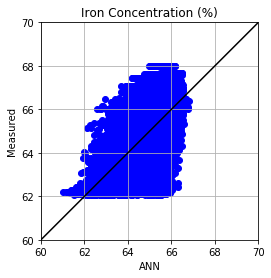

In [62]:
plt.gca().set_aspect('equal')
plt.scatter(aa[aa.columns[0]]*Data['% Iron Concentrate'].std()+Data['% Iron Concentrate'].mean(),Y_test['% Iron Concentrate']*Data['% Iron Concentrate'].std()+Data['% Iron Concentrate'].mean(),color='b')
plt.plot([60,70],[60,70],color='k')
plt.axis([60,70,60,70])
plt.grid(True)
plt.xlabel('ANN')
plt.ylabel('Measured')
plt.title('Iron Concentration (%)')

Text(0.5, 1.0, 'Silica Concentration (%)')

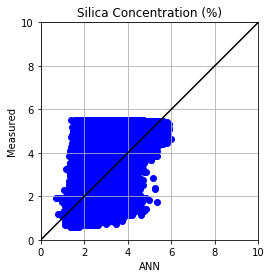

In [63]:
plt.gca().set_aspect('equal')
plt.scatter(aa[aa.columns[1]]*Data['% Silica Concentrate'].std()+Data['% Silica Concentrate'].mean(),Y_test['% Silica Concentrate']*Data['% Silica Concentrate'].std()+Data['% Silica Concentrate'].mean(),color='b')
plt.plot([0,10],[0,10],color='k')
plt.axis([0,10,0,10])
plt.grid(True)
plt.xlabel('ANN')
plt.ylabel('Measured')
plt.title('Silica Concentration (%)')

In [84]:
import numpy as np
np.sqrt((abs(aa[aa.columns[1]]*Data['% Silica Concentrate'].std()+Data['% Silica Concentrate'].mean() - Y_test['% Silica Concentrate'].reset_index(drop=True)*Data['% Silica Concentrate'].std()+Data['% Silica Concentrate'].mean())/(Y_test['% Silica Concentrate'].reset_index(drop=True)*Data['% Silica Concentrate'].std()+Data['% Silica Concentrate'].mean()))*100).mean()

15.477700105407461

In [83]:
import numpy as np
np.sqrt(((aa[aa.columns[0]]*Data['% Iron Concentrate'].std()+Data['% Iron Concentrate'].mean() - Y_test['% Iron Concentrate'].reset_index(drop=True)*Data['% Iron Concentrate'].std()+Data['% Iron Concentrate'].mean())**2).mean())

130.09171960270356

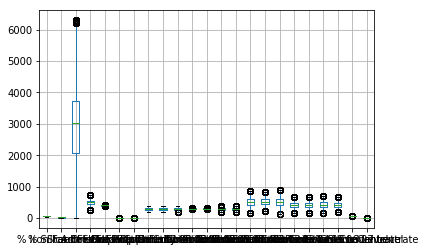

In [68]:
Data.boxplot()